In [17]:
import sys
from pathlib import Path

# 🔧 Append root directory for relative imports
project_root = Path.cwd().resolve().parents[1]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# ✅ Import config values
from src.config import (
    REGION,
    FPA_FOD_DATABASE_NAME,
    FPA_FOD_TABLE_NAME,
    NOAA_DATABASE_NAME,
    NOAA_TABLE_NAME,
    ATHENA_OUTPUT_LOCATION
)

print("✅ Region:", REGION)
print("✅ FPA FOD DB:", FPA_FOD_DATABASE_NAME)
print("✅ FPA FOD Table:", FPA_FOD_TABLE_NAME)
print("✅ NOAA DB:", NOAA_DATABASE_NAME)
print("✅ NOAA Table:", NOAA_TABLE_NAME)
print("✅ Athena Output:", ATHENA_OUTPUT_LOCATION)


✅ Region: us-east-1
✅ FPA FOD DB: wildfirefpafoddb-8xbcuyy0p9z5
✅ FPA FOD Table: ['fpa_fpa_fod']
✅ NOAA DB: wildfirenoaadb-wqk3zt70ai4a
✅ NOAA Table: ['noaa_access']
✅ Athena Output: s3://wildfire-processed-data-863518413936/athena-results/


In [18]:
import boto3
import pandas as pd
import time
import os

athena = boto3.client("athena", region_name=REGION)

def run_athena_query(query, database, output_location=ATHENA_OUTPUT_LOCATION):
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={"Database": database},
        ResultConfiguration={"OutputLocation": output_location},
    )
    execution_id = response["QueryExecutionId"]

    while True:
        status = athena.get_query_execution(QueryExecutionId=execution_id)["QueryExecution"]["Status"]["State"]
        if status == "SUCCEEDED":
            break
        elif status == "FAILED":
            raise Exception(f"Query failed with status: {status}")
        time.sleep(1)

    results = athena.get_query_results(QueryExecutionId=execution_id)
    columns = [col["VarCharValue"] for col in results["ResultSet"]["Rows"][0]["Data"]]
    rows = [[col.get("VarCharValue", None) for col in row["Data"]] for row in results["ResultSet"]["Rows"][1:]]
    return pd.DataFrame(rows, columns=columns)


In [29]:
# 🔍 Sample top 10 rows to understand raw structure
query = f"""
SELECT * FROM {FPA_FOD_TABLE_NAME[0]}
LIMIT 10
"""
df_sample = run_athena_query(query, FPA_FOD_DATABASE_NAME)
df_sample.head()


,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_fire_report_id,...,fire_size,fire_size_class,latitude,longitude,owner_descr,state,county,fips_code,fips_name,geometry
0,300201486,FS-6348179,FED,FS-FIRESTAT,FS,USUTFIF,Fishlake National Forest,408,Fishlake National Forest,23,...,0.1,A,38.89666667,-111.53972222,USFS,UT,41,49041,Sevier County,POINT (-111.53971078999996 38.89666082200006)
1,300201487,FS-6347045,FED,FS-FIRESTAT,FS,USUTFIF,Fishlake National Forest,408,Fishlake National Forest,30,...,0.1,A,38.65861111,-112.55805556,USFS,UT,27,49027,Millard County,POINT (-112.55804395499996 38.65860536300005)
2,300201488,FS-6346992,FED,FS-FIRESTAT,FS,USUTFIF,Fishlake National Forest,408,Fishlake National Forest,28,...,0.1,A,39.28472222,-112.28138889,USFS,UT,27,49027,Millard County,POINT (-112.28137726499995 39.28471638000008)
3,300201489,FS-6352770,FED,FS-FIRESTAT,FS,USUTFIF,Fishlake National Forest,408,Fishlake National Forest,34,...,0.1,A,38.3625,-112.43416667,USFS,UT,1,49001,Beaver County,POINT (-112.43415512299998 38.36249427900003)
4,300201490,FS-6366035,FED,FS-FIRESTAT,FS,USUTFIF,Fishlake National Forest,408,Fishlake National Forest,36,...,0.25,A,38.16027778,-112.46611111,USFS,UT,1,49001,Beaver County,POINT (-112.46609957999999 38.16027208500003)


In [36]:
query = f"""
DESCRIBE {FPA_FOD_TABLE_NAME[0]}
"""
df_schema_raw = run_athena_query(query, FPA_FOD_DATABASE_NAME)
print("🔍 Raw schema output from Athena:")
print(df_schema_raw)



🔍 Raw schema output from Athena:
   fod_id              \tbigint              \t                    
0   fpa_id              \tstring              \t  ...              
1   source_system_type  \tstring              \t  ...              
2   source_system       \tstring              \t  ...              
3   nwcg_reporting_agency\tstring              \t ...              
4   nwcg_reporting_unit_id\tstring              \t...              
5   nwcg_reporting_unit_name\tstring              ...              
6   source_reporting_unit\tbigint              \t ...              
7   source_reporting_unit_name\tstring            ...              
8   local_fire_report_id\tbigint              \t  ...              
9   local_incident_id   \tstring              \t  ...              
10  fire_code           \tstring              \t  ...              
11  fire_name           \tstring              \t  ...              
12  ics_209_plus_incident_join_id\tstring         ...              
13  ics_209_plu

In [39]:
# Step 1: Rename single column and clean whitespace
df_schema_raw.columns = ["raw"]
df_schema_raw["raw"] = df_schema_raw["raw"].str.strip()

# Step 2: Split by tab character (`\t`)
df_schema_split = df_schema_raw["raw"].str.split("\t", expand=True)

# Step 3: Assign column names safely
df_schema_split.columns = ["column_name", "data_type"]

# Step 4: Drop empty rows and nulls
df_schema = df_schema_split[["column_name", "data_type"]].dropna()
df_schema = df_schema[df_schema["column_name"].str.strip() != ""].reset_index(drop=True)

# ✅ Preview
print("✅ Parsed schema columns:")
print(df_schema)


✅ Parsed schema columns:
                      column_name data_type
0            fpa_id                  string
1            source_system_type      string
2            source_system           string
3           nwcg_reporting_agency    string
4          nwcg_reporting_unit_id    string
5        nwcg_reporting_unit_name    string
6           source_reporting_unit    bigint
7      source_reporting_unit_name    string
8            local_fire_report_id    bigint
9            local_incident_id       string
10           fire_code               string
11           fire_name               string
12  ics_209_plus_incident_join_id    string
13   ics_209_plus_complex_join_id    string
14           mtbs_id                 string
15           mtbs_fire_name          string
16           complex_name            string
17           fire_year               bigint
18           discovery_date          string
19           discovery_doy           bigint
20           discovery_time          bigint
21     

In [42]:
column_names = df_schema["column_name"].tolist()
excluded_cols = ["geometry"]  # Skip spatial/complex fields
cols_to_check = [col for col in column_names if col not in excluded_cols]

# Build the SELECT clause — no aliasing or backticks
select_lines = [
    f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) * 100.0 / COUNT(*)"
    for col in cols_to_check
]

nulls_query = f"""
SELECT {', '.join(select_lines)}
FROM {FPA_FOD_TABLE_NAME[0]}
"""

# ------------------------------------------
# Step 3: Run and format output
# ------------------------------------------
df_nulls = run_athena_query(nulls_query, FPA_FOD_DATABASE_NAME)

# Assign column names manually since we didn't use aliases
df_nulls.columns = [f"{col}_null_pct" for col in cols_to_check]
df_nulls = df_nulls.T.reset_index()
df_nulls.columns = ["column", "null_percentage"]
df_nulls["null_percentage"] = pd.to_numeric(df_nulls["null_percentage"], errors="coerce").round(2)

# Display top 20
df_nulls.sort_values("null_percentage", ascending=False).head(20)

,column,null_percentage
33,county _null_pct,92.32
6,source_reporting_unit_null_pct,88.16
8,local_fire_report_id_null_pct,79.52
26,cont_time _null_pct,43.50
25,cont_doy _null_pct,40.48
34,fips_code _null_pct,34.10
20,discovery_time _null_pct,32.72
17,fire_year _null_pct,5.55
19,discovery_doy _null_pct,5.01
29,latitude _null_pct,5.01


In [51]:
query = f"""
SELECT 
  fire_size_class,
  COUNT(*) AS count
FROM {FPA_FOD_TABLE_NAME[0]}
GROUP BY fire_size_class
ORDER BY count DESC
"""
df_size_class = run_athena_query(query, FPA_FOD_DATABASE_NAME)

In [53]:
print(df_size_class.head(50))

   fire_size_class    count
0                B  1049456
1                A   812858
2                C   249115
3                D    33175
4              0.1    21347
5                E    16839
6             0.01    11911
7                F     9515
8              1.0     9273
9                G     4723
10             0.5     4415
11            0.25     3968
12            0.11     3383
13             0.2     3340
14             2.0     2568
15             0.3     1657
16            0.05     1400
17            0.02     1393
18             3.0     1286
19             5.0     1052
20            0.21     1007
21            1800      863
22             1.5      846
23            0.12      784
24            0.15      767
25             4.0      738
26            0.03      716
27             0.4      675
28            2000      601
29            10.0      557
30            0.04      554
31            0.08      544
32             0.6      539
33            0.06      506
34            0.13  

In [45]:
query = f"""
SELECT 
  fire_year,
  COUNT(*) AS fire_count
FROM {FPA_FOD_TABLE_NAME[0]}
GROUP BY fire_year
ORDER BY fire_year
"""
df_yearly = run_athena_query(query, FPA_FOD_DATABASE_NAME)


In [46]:
print(df_yearly)

   fire_year fire_count
0         47          1
1       1992      67308
2       1993      61497
3       1994      74926
4       1995      70862
5       1996      74716
6       1997      61010
7       1998      67954
8       1999      88798
9       2000      95405
10      2001      86201
11      2002      75525
12      2003      62812
13      2004      60673
14      2005      82683
15      2006     104563
16      2007      86076
17      2008      77852
18      2009      72392
19      2010      81726
20      2011      95399
21      2012      72977
22      2013      64435
23      2014      69658
24      2015      76916
25      2016      74535
26      2017      74080
27      2018      72343
28      2019      57768
29      2020      64591
30      None     127884


In [ ]:
query = f"""
SELECT 
  nwcg_general_cause,
  COUNT(*) AS fire_count
FROM {FPA_FOD_TABLE_NAME[0]}
GROUP BY nwcg_general_cause
ORDER BY fire_count DESC
"""
df_cause = run_athena_query(query, FPA_FOD_DATABASE_NAME)

In [54]:
print(df_cause.head(50))

                            nwcg_general_cause fire_count
0      Missing data/not specified/undetermined     581801
1                      Debris and open burning     507213
2                                      Natural     317904
3                           Arson/incendiarism     305738
4                    Equipment and vehicle use     177087
5                      Recreation and ceremony      97231
6                                        Human      82797
7                    Misuse of fire by a minor      61576
8                                      Smoking      59983
9          Railroad operations and maintenance      36349
10  Power generation/transmission/distribution      31760
11                                   Fireworks      18407
12                                Other causes      10411
13                 Firearms and explosives use       2709
14                                                    264
15                                        1600        199
16            

In [ ]:
query = f"""
SELECT 
  state,
  COUNT(*) AS fire_count
FROM {FPA_FOD_TABLE_NAME[0]}
GROUP BY state
ORDER BY fire_count DESC
"""
df_states = run_athena_query(query, FPA_FOD_DATABASE_NAME)

In [56]:
print(df_states.head(60))

                    state fire_count
0                      CA     196831
1                      TX     178870
2                      GA     139774
3                      NC     130130
4                      AZ     104950
5                      FL     103380
6                      NY      99139
7                      SC      88051
8                      MS      84706
9                      OR      71431
10                     AL      70213
11  MISSING/NOT SPECIFIED      58008
12                     CO      54773
13                     MT      51936
14                     MN      51066
15                     OK      50187
16                     NM      43576
17                PRIVATE      42897
18                     ID      42008
19                     WA      40771
20                     WI      38180
21                     AR      37946
22                     SD      36377
23                     TN      34513
24                     UT      32797
25                     NJ      32246
2

In [66]:
query = f"""
SELECT 
  MIN(fire_size) AS min_fire_size,
  MAX(fire_size) AS max_fire_size,
  AVG(fire_size) AS avg_fire_size,
  APPROX_PERCENTILE(fire_size, 0.5) AS median_fire_size,
  COUNT(*) AS total_records
FROM {FPA_FOD_TABLE_NAME[0]}
WHERE fire_size IS NOT NULL AND fire_size > 1000
"""
df_fire_stats = run_athena_query(query, FPA_FOD_DATABASE_NAME)
display(df_fire_stats)


,min_fire_size,max_fire_size,avg_fire_size,median_fire_size,total_records
0,1000.1,662700.0,5335.369235750375,1728.5811226300432,35429


In [67]:
query = f"""
SELECT 
  fire_size
FROM {FPA_FOD_TABLE_NAME[0]}
WHERE fire_size IS NOT NULL AND fire_size > 1000
"""
df_size = run_athena_query(query, FPA_FOD_DATABASE_NAME)
df_size["fire_size"] = pd.to_numeric(df_size["fire_size"], errors="coerce")


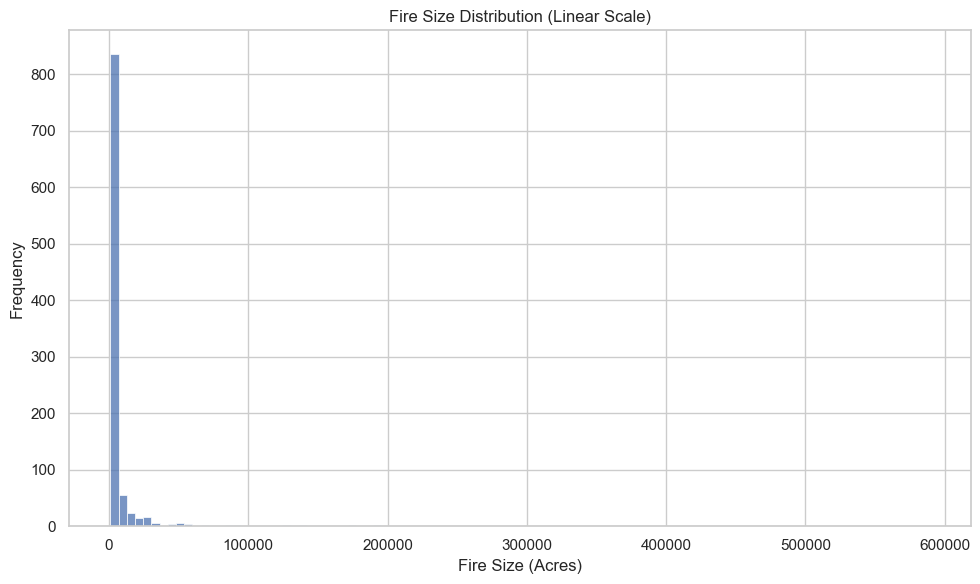

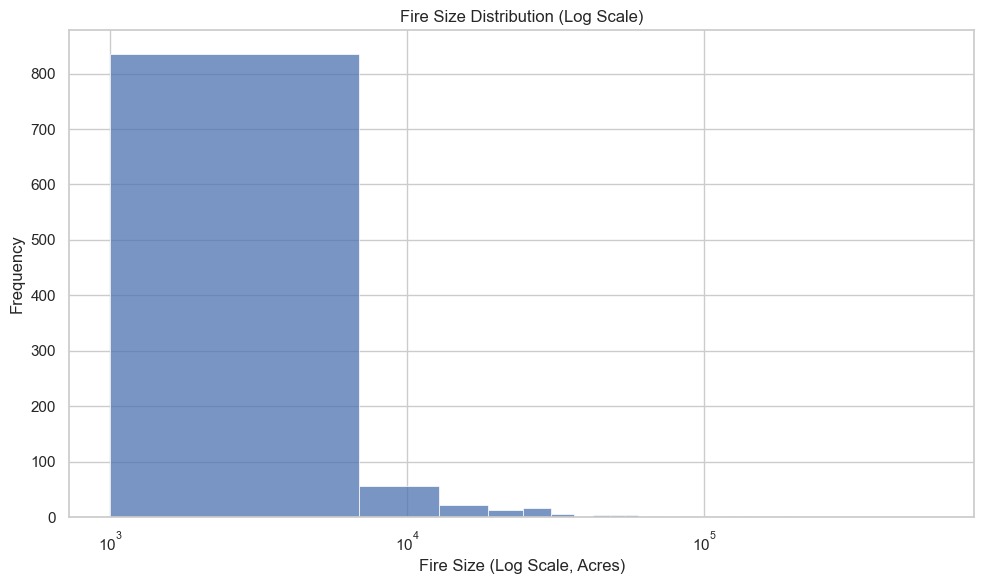

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_size["fire_size"], bins=100, kde=False)
plt.title("Fire Size Distribution (Linear Scale)")
plt.xlabel("Fire Size (Acres)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optional: log scale to reveal small fire detail
plt.figure(figsize=(10, 6))
sns.histplot(df_size["fire_size"], bins=100, kde=False)
plt.xscale("log")
plt.title("Fire Size Distribution (Log Scale)")
plt.xlabel("Fire Size (Log Scale, Acres)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [69]:
query = f"""
SELECT 
  nwcg_general_cause,
  AVG(fire_size) AS avg_size,
  MAX(fire_size) AS max_size,
  COUNT(*) AS total_fires
FROM {FPA_FOD_TABLE_NAME[0]}
WHERE fire_size IS NOT NULL and fire_size > 1000
GROUP BY nwcg_general_cause
ORDER BY total_fires DESC
"""

df_cause_stats = run_athena_query(query, FPA_FOD_DATABASE_NAME)

In [70]:
print(df_cause_stats.head(50))

                            nwcg_general_cause            avg_size  max_size  \
0                                        Human  1611.4295520732214    2359.0   
1                                      Natural   9905.495848667419  606945.0   
2      Missing data/not specified/undetermined   5087.962354637923  662700.0   
3                           Arson/incendiarism   5980.064160931174  259158.9   
4                    Equipment and vehicle use    8108.10796736842  410203.0   
5                      Debris and open burning   4561.412659574469  162702.0   
6   Power generation/transmission/distribution   8469.152777777777  197990.0   
7                      Recreation and ceremony   13813.40010752688  538049.0   
8          Railroad operations and maintenance  5176.3267326732675   58707.4   
9                                      Smoking   6768.505434782609   58501.0   
10                 Firearms and explosives use  6508.0344827586205   81826.0   
11                                   Fir

In [71]:
query = f"""
SELECT 
  state,
  nwcg_general_cause,
  COUNT(*) AS fire_count
FROM {FPA_FOD_TABLE_NAME[0]}
WHERE fire_size IS NOT NULL AND fire_size > 1000
GROUP BY state, nwcg_general_cause
ORDER BY fire_count DESC
"""

df_state_cause = run_athena_query(query, FPA_FOD_DATABASE_NAME)

In [72]:
print(df_state_cause.head(50))

                    state                          nwcg_general_cause  \
0   MISSING/NOT SPECIFIED                                       Human   
1   MISSING/NOT SPECIFIED     Missing data/not specified/undetermined   
2                 PRIVATE                                       Human   
3                     BLM                                     Natural   
4                      AK                                     Natural   
5                      ID                                     Natural   
6                    USFS                                     Natural   
7                 PRIVATE                                     Natural   
8                      NV                                     Natural   
9                      OR                                     Natural   
10                     MT                                     Natural   
11                     AZ                                     Natural   
12                   USFS                          

In [78]:
# Total number of rows
query = f"""
SELECT COUNT(*) AS row_count
FROM {NOAA_TABLE_NAME[0]}
"""
df_row_count = run_athena_query(query, NOAA_DATABASE_NAME)
print("✅ Total Rows:", df_row_count.iloc[0]['row_count'])

# Number of columns
query = f"""
DESCRIBE {NOAA_TABLE_NAME[0]}
"""
df_schema_raw_noaa = run_athena_query(query, NOAA_DATABASE_NAME)
print("🔍 Raw schema output from Athena:")
print(df_schema_raw_noaa)

✅ Total Rows: 5715090
🔍 Raw schema output from Athena:
    station             \tstring              \t                    
0    date                \tstring              \t  ...              
1    latitude            \tdouble              \t  ...              
2    longitude           \tdouble              \t  ...              
3    elevation           \tdouble              \t  ...              
4    name                \tstring              \t  ...              
..                                                 ...              
287  years_dly-snwd-50pctl\tbigint              \t ...              
288  dly-snwd-75pctl     \tdouble              \t  ...              
289  meas_flag_dly-snwd-75pctl\tstring             ...              
290  comp_flag_dly-snwd-75pctl\tstring             ...              
291  years_dly-snwd-75pctl\tbigint              \t ...              

[292 rows x 1 columns]


In [79]:
# Step 1: Rename single column and clean whitespace
df_schema_raw_noaa.columns = ["raw"]
df_schema_raw_noaa["raw"] = df_schema_raw_noaa["raw"].str.strip()

# Step 2: Split by tab character (`\t`)
df_schema_split_noaa = df_schema_raw_noaa["raw"].str.split("\t", expand=True)

# Step 3: Assign column names safely
df_schema_split_noaa.columns = ["column_name", "data_type"]

# Step 4: Drop empty rows and nulls
df_schema_noaa = df_schema_split_noaa[["column_name", "data_type"]].dropna()
df_schema_noaa = df_schema_noaa[df_schema_noaa["column_name"].str.strip() != ""].reset_index(drop=True)

# ✅ Preview
print("✅ Parsed schema columns:")
print(df_schema_noaa)


✅ Parsed schema columns:
                   column_name data_type
0         date                    string
1         latitude                double
2         longitude               double
3         elevation               double
4         name                    string
..                         ...       ...
287      years_dly-snwd-50pctl    bigint
288       dly-snwd-75pctl         double
289  meas_flag_dly-snwd-75pctl    string
290  comp_flag_dly-snwd-75pctl    string
291      years_dly-snwd-75pctl    bigint

[292 rows x 2 columns]


In [81]:
all_columns = df_schema_noaa["column_name"].tolist()
print("📌 Total Columns:", len(all_columns))
for col in all_columns:
    print(col)


📌 Total Columns: 292
date                
latitude            
longitude           
elevation           
name                
month               
day                 
hour                
dly-prcp-pctall-ge001hi
meas_flag_dly-prcp-pctall-ge001hi
comp_flag_dly-prcp-pctall-ge001hi
years_dly-prcp-pctall-ge001hi
dly-prcp-pctall-ge010hi
meas_flag_dly-prcp-pctall-ge010hi
comp_flag_dly-prcp-pctall-ge010hi
years_dly-prcp-pctall-ge010hi
dly-prcp-pctall-ge025hi
meas_flag_dly-prcp-pctall-ge025hi
comp_flag_dly-prcp-pctall-ge025hi
years_dly-prcp-pctall-ge025hi
dly-prcp-pctall-ge050hi
meas_flag_dly-prcp-pctall-ge050hi
comp_flag_dly-prcp-pctall-ge050hi
years_dly-prcp-pctall-ge050hi
dly-prcp-pctall-ge100hi
meas_flag_dly-prcp-pctall-ge100hi
comp_flag_dly-prcp-pctall-ge100hi
years_dly-prcp-pctall-ge100hi
dly-prcp-pctall-ge200hi
meas_flag_dly-prcp-pctall-ge200hi
comp_flag_dly-prcp-pctall-ge200hi
years_dly-prcp-pctall-ge200hi
dly-prcp-pctall-ge400hi
meas_flag_dly-prcp-pctall-ge400hi
comp_flag_dly-prcp-pc

In [89]:
import boto3
import pandas as pd
import time
import io

def run_athena_query_s3(query, database, output_location=ATHENA_OUTPUT_LOCATION):
    # 1. Start query
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={"Database": database},
        ResultConfiguration={"OutputLocation": output_location},
    )
    execution_id = response["QueryExecutionId"]

    # 2. Wait for query completion
    while True:
        status = athena.get_query_execution(QueryExecutionId=execution_id)["QueryExecution"]["Status"]["State"]
        if status == "SUCCEEDED":
            break
        elif status == "FAILED":
            raise Exception("Query failed")
        time.sleep(1)

    # 3. Build S3 path to result CSV
    s3 = boto3.client("s3")
    bucket = output_location.replace("s3://", "").split("/")[0]
    prefix = "/".join(output_location.replace("s3://", "").split("/")[1:])
    key = f"{prefix}{execution_id}.csv"

    # 4. Read and return as DataFrame
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(io.BytesIO(obj["Body"].read()))

# ✅ 15 selected columns
cols_to_check = [
    "dly-prcp-pctall-ge001hi", "dly-prcp-pctall-ge100hi",
    "dly-prcp-25pctl", "dly-prcp-50pctl", "dly-prcp-75pctl",
    "mtd-prcp-normal", "ytd-prcp-normal",
    "dly-snow-pctall-ge010ti", "dly-snow-50pctl", "dly-snwd-50pctl",
    "ytd-snow-normal",
    "dly-tavg-normal", "dly-tmin-normal", "dly-tmax-normal", "dly-dutr-normal"
]

# ✅ Build query using double quotes
select_lines = [
    f'SUM(CASE WHEN "{col}" IS NULL THEN 1 ELSE 0 END) * 100.0 / COUNT(*)'
    for col in cols_to_check
]

query = f"""
SELECT {', '.join(select_lines)}
FROM {NOAA_TABLE_NAME[0]}
"""

# ✅ Run via S3 and format result
df_nulls_subset = run_athena_query_s3(query, NOAA_DATABASE_NAME)
df_nulls_subset.columns = [f"{col}_null_pct" for col in cols_to_check]
df_nulls_subset = df_nulls_subset.T.reset_index()
df_nulls_subset.columns = ["column", "null_percentage"]
df_nulls_subset["null_percentage"] = pd.to_numeric(df_nulls_subset["null_percentage"], errors="coerce").round(2)

# 🔍 View results
df_nulls_subset.sort_values("null_percentage", ascending=False)


,column,null_percentage
0,dly-prcp-pctall-ge001hi_null_pct,100.0
1,dly-prcp-pctall-ge100hi_null_pct,100.0
2,dly-prcp-25pctl_null_pct,100.0
3,dly-prcp-50pctl_null_pct,100.0
4,dly-prcp-75pctl_null_pct,100.0
5,mtd-prcp-normal_null_pct,100.0
6,ytd-prcp-normal_null_pct,100.0
7,dly-snow-pctall-ge010ti_null_pct,100.0
8,dly-snow-50pctl_null_pct,100.0
9,dly-snwd-50pctl_null_pct,100.0


In [80]:
query = f"""
SELECT *
FROM {NOAA_TABLE_NAME[0]}
LIMIT 10
"""
df_sample = run_athena_query(query, NOAA_DATABASE_NAME)
display(df_sample)


,station,date,latitude,longitude,elevation,name,month,day,hour,dly-prcp-pctall-ge001hi,...,comp_flag_dly-snwd-25pctl,years_dly-snwd-25pctl,dly-snwd-50pctl,meas_flag_dly-snwd-50pctl,comp_flag_dly-snwd-50pctl,years_dly-snwd-50pctl,dly-snwd-75pctl,meas_flag_dly-snwd-75pctl,comp_flag_dly-snwd-75pctl,years_dly-snwd-75pctl
0,"""US1CAHM0060""","""01-01""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"""US1CAHM0060""","""01-02""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"""US1CAHM0060""","""01-03""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"""US1CAHM0060""","""01-04""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"""US1CAHM0060""","""01-05""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,"""US1CAHM0060""","""01-06""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,"""US1CAHM0060""","""01-07""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,"""US1CAHM0060""","""01-08""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,"""US1CAHM0060""","""01-09""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,"""US1CAHM0060""","""01-10""",None,None,None,"""TRINIDAD 0.2 NE",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
